In [2]:
from DLtools.Data_preprocess import load_data
from DLtools.evaluation_rec import real_eva_error,error_rec,list_eva_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten, LSTM, RepeatVector,TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)

In [3]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # store
        scores.append(mse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    #score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))
    score = (s / (actual.shape[0] * actual.shape[1]))
    return score, scores

def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df

In [4]:
def train_test(data,n_out):    
    ratio = int(len(data)*.7)
    d_start = int(ratio-ratio%n_out)
    d_end = int(len(data)-len(data)%n_out)
    #train,test = X_in.iloc[:700,:].values,X_in.iloc[700:777,:].values
    train,test = data[:d_start,:],data[d_start:d_end,:]

    train = np.array(np.split(train, len(train)/n_out))
    test = np.array(np.split(test, len(test)/n_out))
    return train,test

def to_supervised(train, n_input, n_out=7):
    # flatten data
    try :
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    except:
        data = train.values
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out   
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])   #Y is the first columns
        # move along one time step
        in_start += 1
    return np.array(X), np.array(y)

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat


In [5]:
def build_model_seq2seq(train, n_in,n_out):
    # Train-val split
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    train,val = train_test(data,n_out)
    # define parameters
    train_x, train_y = to_supervised(train, n_in,n_out)
    val_x, val_y = to_supervised(val, n_input,n_out)
    validation = (val_x,val_y)

    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    callback_early_stopping = EarlyStopping(monitor='val_loss',patience=10, verbose=2)
    callbacks = [callback_early_stopping]


    # define model
    verbose, epochs, batch_size = 0, 50, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))                                  # Decoder 
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    # fit network
    history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,
    validation_data=validation,callbacks=callbacks)
    try:
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    except: pass
    return model

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model_seq2seq(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))


In [6]:
index = ["Model","MSE","NSE"]
error_df = pd.DataFrame(index=index)

def Rec(model,mse,nse):
    _index = ["Model","MSE","NSE"]
    _df = pd.DataFrame(data=[model,mse,nse],index=_index)
    return pd.concat([error_df,_df],axis=1)

In [7]:
r='data/instant_data/rain_small.csv'
w='data/instant_data/water_small.csv'
rw = load_data(r,w)
df =rw.df.resample('d').mean().astype('float32')

DataFrame shape: (465169, 35)


In [8]:
data = df["2015-01-01":"2018-01-05"].interpolate(limit=360)
# data = df.fillna(0)
# data = df.interpolate(limit=7)

In [9]:
TARGET = 'CPY015_w'
data = move_column_inplace(data,TARGET,0)
data.head()

,CPY015_w,CHM002_r,CHM004_r,CHM006_r,CPY004_r,CPY009_r,CPY010_r,CPY015_r,KWN002_r,NAN006_r,...,CPY010_w,KWN002_w,NAN009_w,NAN010_w,NAN011_w,NAN012_w,NAN013_w,PIN001_w,PIN004_w,THA001_w
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.480214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.691944,43.100971,179.443604,154.378952,52.498749,36.744793,40.589653,118.766808,40.585140,14.123750
2015-01-02,0.497222,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.699167,43.026737,179.438538,154.385696,52.471527,36.745209,40.576504,118.704041,40.612335,14.161667
2015-01-03,0.449130,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.682847,42.988644,179.431366,154.357910,52.515541,36.733955,40.564930,118.735382,40.563164,14.194637
2015-01-04,0.408849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.633944,43.035347,179.420761,154.375412,52.496181,36.600418,40.561043,118.749115,40.574341,14.195209
2015-01-05,0.481667,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.695000,43.032043,179.423615,154.377808,52.465843,36.713593,40.541759,118.822998,40.559639,14.182285


In [10]:
#SCALE
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])

In [11]:
n_in = 14
n_out = 7

# score, scores = evaluate_model(train, test, n_input)
# # summarize scores
# summarize_scores('lstm_seq2seqtraintraintrain', score, scores)

# Modify 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               188800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 1)              101       
Total params: 529,801
Trainable params: 529,801
Non-trainable params: 0
_________________________________________________________________
Epoch 00015: early stopping


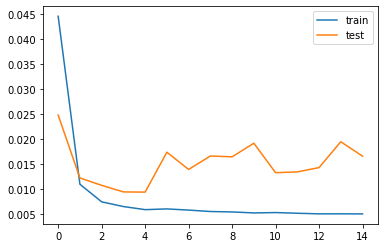

In [12]:
n_input = 14
n_out = 7

train, test = train_test(data.values,n_out=n_out)
train_x, train_y = to_supervised(train, n_in,n_out)
test_x, test_y = to_supervised(test, n_in,n_out)

model = build_model_seq2seq(train,n_input,n_out)

In [13]:
# get prdict result as once
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

mse, nse = list_eva_error(train_y, trainPredict,n_out)
Tmse, Tnse = list_eva_error(test_y, testPredict,n_out)

for d in range(n_out):
    print("Day{}........MSE:{:.3f},NSE:{:.3f}| (test)MSE:{:.3f},NSE:{:.3f}".format(d+1,mse[d],nse[d],Tmse[d],Tnse[d]))
    #print(Tmse,Tnse)
# summarize_scores('seq2seq_inOnce(train)',score,scores)
# summarize_scores('seq2seq_inOnce(Test)',Tscore,Tscores)

Day1........MSE:0.008,NSE:0.501| (test)MSE:0.017,NSE:0.351
Day2........MSE:0.008,NSE:0.479| (test)MSE:0.021,NSE:0.191
Day3........MSE:0.008,NSE:0.470| (test)MSE:0.022,NSE:0.162
Day4........MSE:0.008,NSE:0.473| (test)MSE:0.022,NSE:0.155
Day5........MSE:0.008,NSE:0.473| (test)MSE:0.022,NSE:0.153
Day6........MSE:0.008,NSE:0.461| (test)MSE:0.022,NSE:0.149
Day7........MSE:0.009,NSE:0.441| (test)MSE:0.022,NSE:0.157


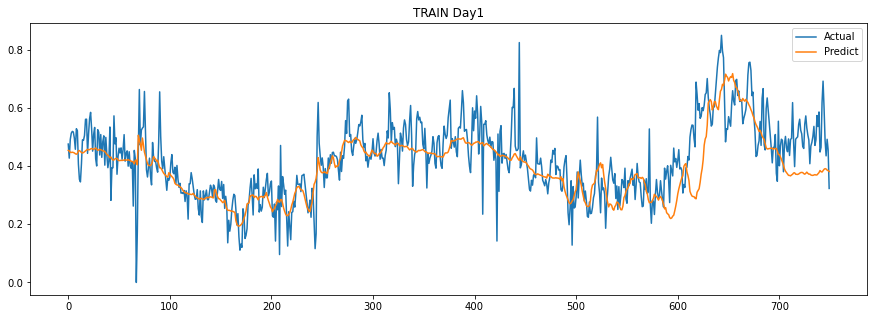

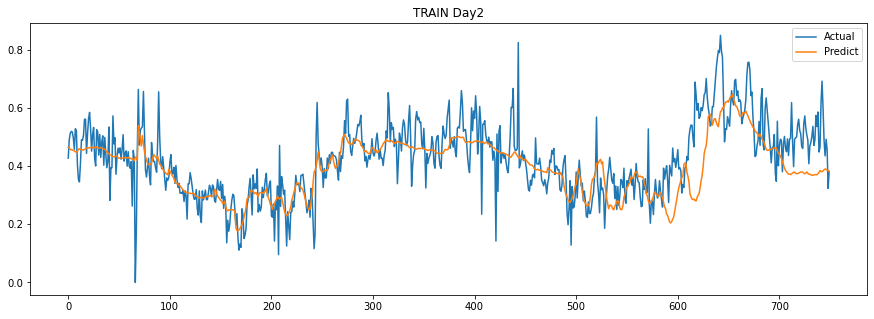

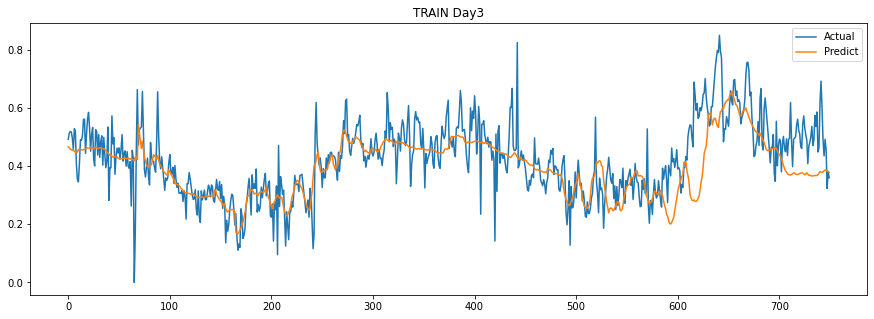

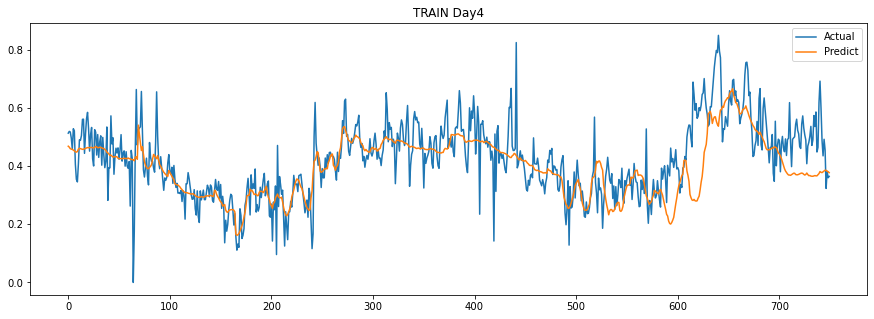

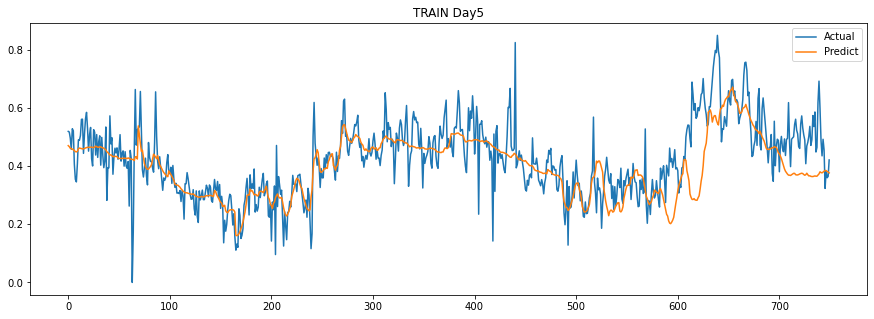

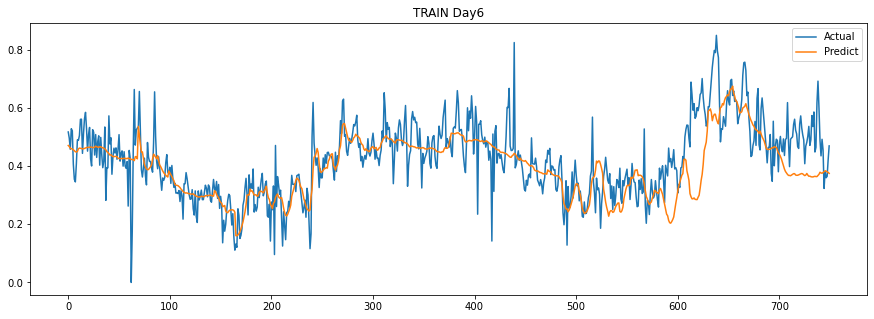

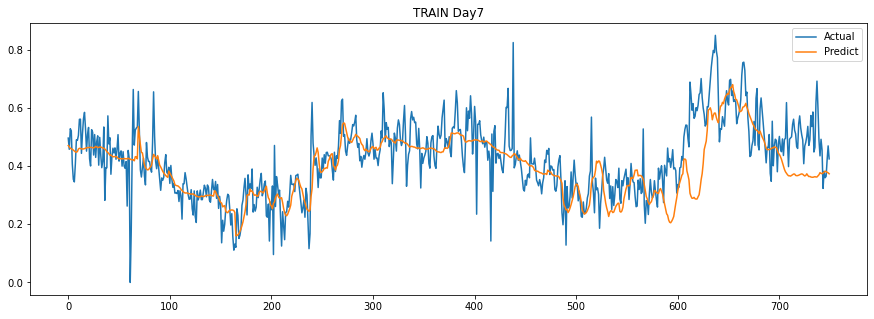

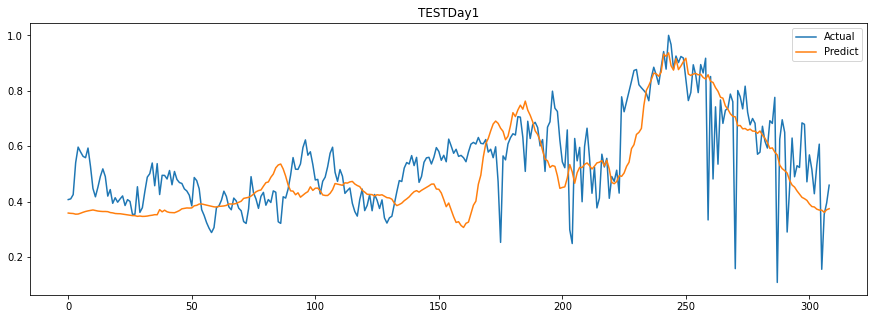

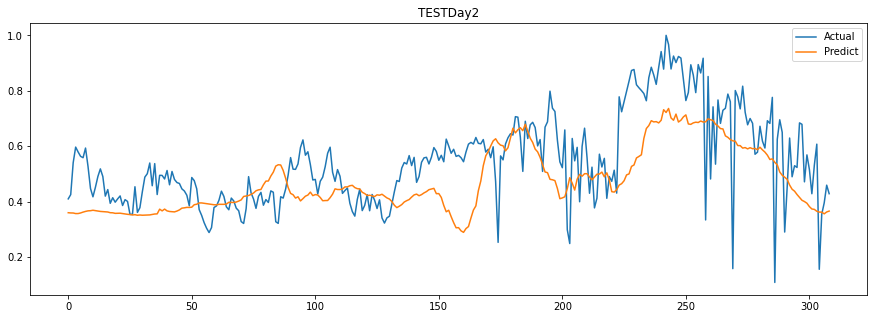

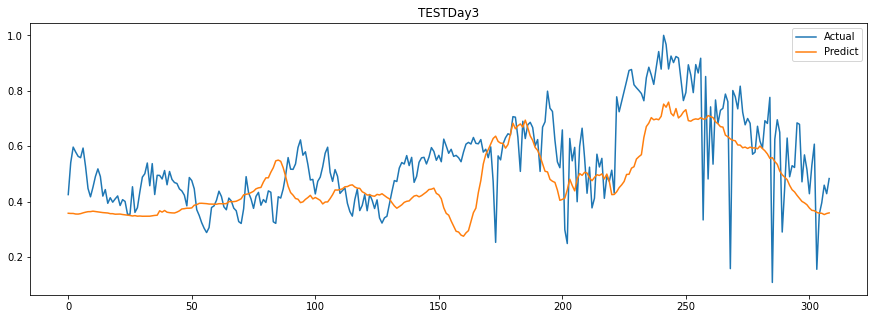

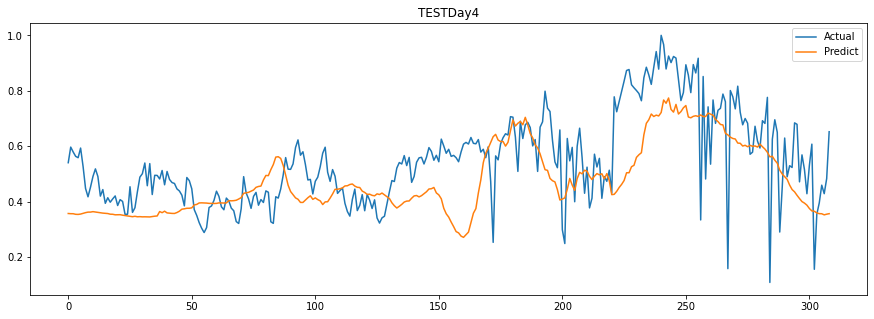

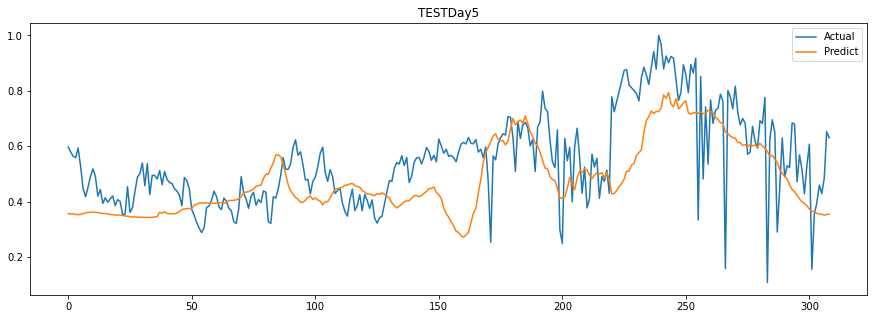

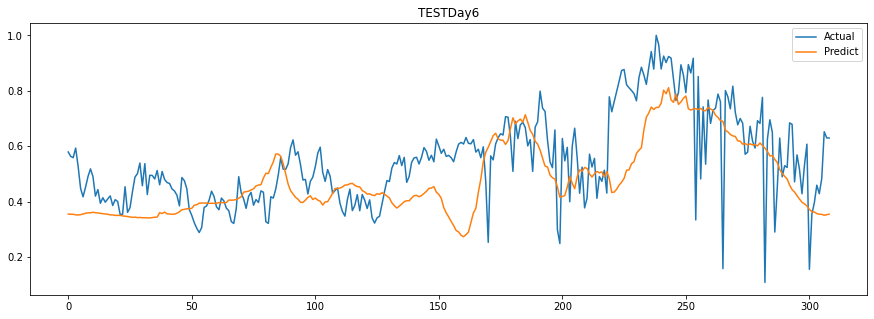

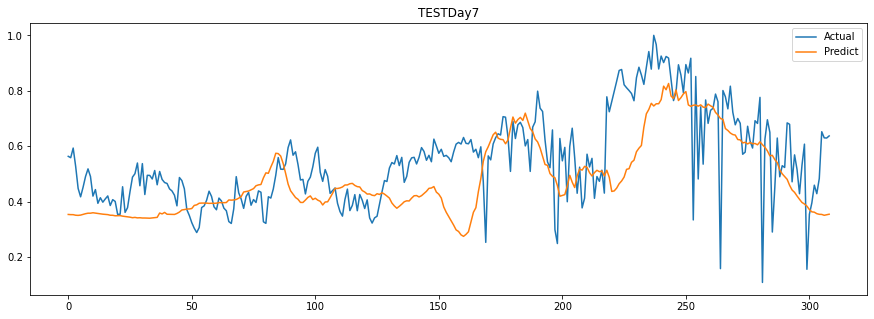

In [14]:

for i in range(n_out):
    plt.figure(figsize=(15,5))
    plt.plot(train_y[:,i], label = "Actual")
    plt.plot(trainPredict[:,i], label = "Predict")
    plt.title('TRAIN Day{}'.format(i+1))
    plt.legend()
    plt.show()

for i in range(n_out):
    plt.figure(figsize=(15,5))
    plt.plot(test_y[:,i], label = "Actual")
    plt.plot(testPredict[:,i], label = "Predict")
    plt.title('TESTDay{}'.format(i+1))
    plt.legend()
    plt.show()

In [15]:
error_df = Rec("LSTM_seq2seq",Tmse,Tnse)

# walkalong prediction

In [16]:
#GET PREDICTION by keep feeding new update#
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input) # model.predict(x)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = np.array(predictions)

In [17]:
mse,nse = list_eva_error(test[:,:,0], predictions,n_out)
for d in range(n_out):
    print("Day{}........ (test)MSE:{:.3f},NSE:{:.3f}".format(d+1,mse[d],nse[d]))

Day1........ (test)MSE:0.027,NSE:0.020
Day2........ (test)MSE:0.020,NSE:0.220
Day3........ (test)MSE:0.021,NSE:0.077
Day4........ (test)MSE:0.023,NSE:-0.076
Day5........ (test)MSE:0.028,NSE:-0.008
Day6........ (test)MSE:0.020,NSE:0.222
Day7........ (test)MSE:0.020,NSE:0.137


In [18]:
# Val_score, Val_scores = evaluate_forecasts(test[:,:,0], predictions) # check test result of "Y" (CPY015) only
# summarize_scores('seq2seq_walkVal(test)',Val_score,Val_scores)

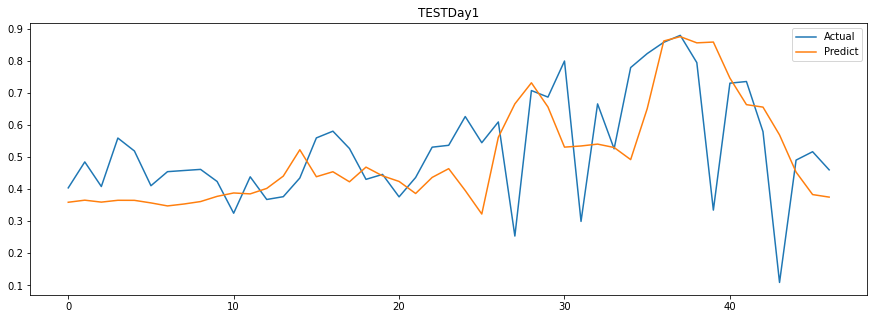

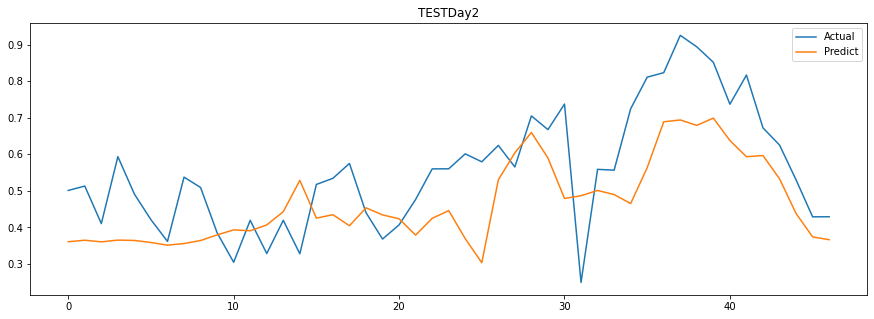

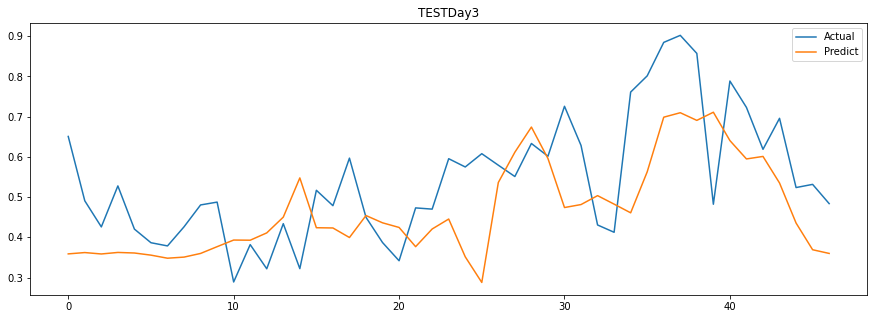

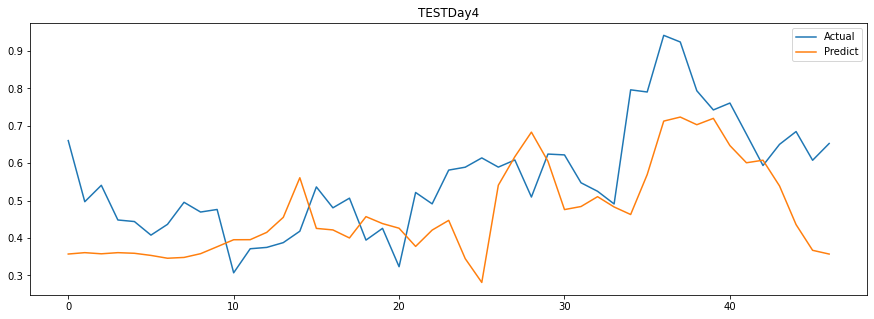

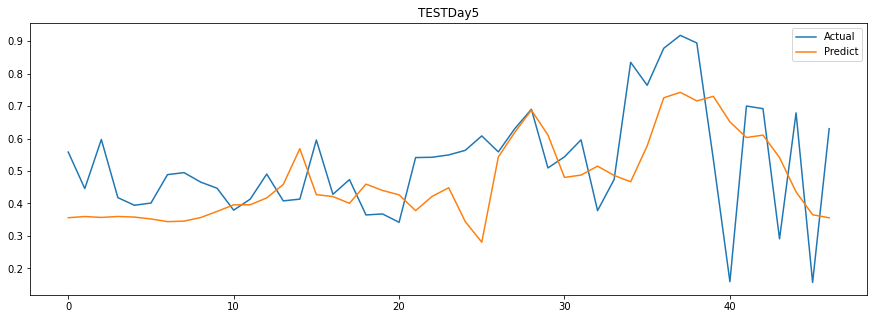

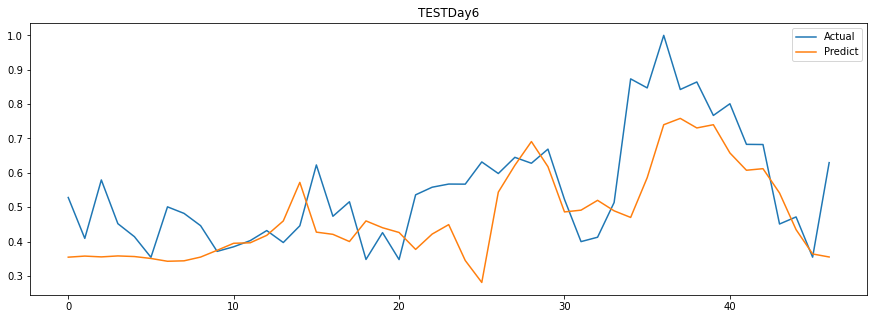

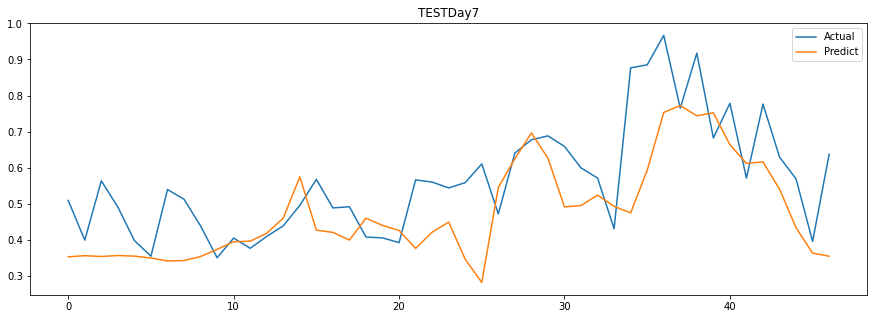

In [19]:
for i in range(test.shape[1]):
    plt.figure(figsize=(15,5))
    plt.plot(test[:,i,0],label = 'Actual')
    plt.plot(predictions[:,i,:],label = 'Predict')
    plt.title('TESTDay{}'.format(i+1))
    plt.legend()
    plt.show()

# LSTM simple

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               188800    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 200)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 200)            320800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 100)            20100     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 1)              101       
Total params: 529,801
Trainable params: 529,801
Non-trainable params: 0
_________________________________________________________________
Epoch 00017: early stopping


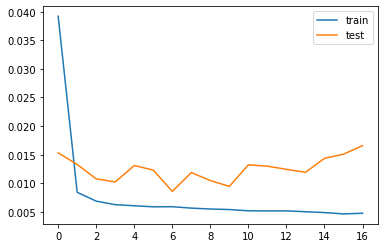

In [20]:
def build_model_lstm(train,n_in,n_out):
    # Train-val split
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    train,val = train_test(data,n_out)
    # define parameters
    train_x, train_y = to_supervised(train, n_in,n_out)
    val_x, val_y = to_supervised(val, n_input,n_out)
    validation = (val_x,val_y)

    verbose, epochs, batch_size = 0, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    model.summary()
    # fit network
    history =  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_data=validation)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    return model
    
model2 = build_model_seq2seq(train,n_input,n_out)

In [21]:
# get prdict result as once
trainPredict = model.predict(train_x)
testPredict = model.predict(test_x)

mse, nse = list_eva_error(train_y, trainPredict,n_out)
Tmse, Tnse = list_eva_error(test_y, testPredict,n_out)

for d in range(n_out):
    print("Day{}........MSE:{:.3f},NSE:{:.3f}| (test)MSE:{:.3f},NSE:{:.3f}".format(d+1,mse[d],nse[d],Tmse[d],Tnse[d]))
    #print(Tmse,Tnse)
# summarize_scores('seq2seq_inOnce(train)',score,scores)
# summarize_scores('seq2seq_inOnce(Test)',Tscore,Tscores)

Day1........MSE:0.008,NSE:0.501| (test)MSE:0.017,NSE:0.351
Day2........MSE:0.008,NSE:0.479| (test)MSE:0.021,NSE:0.191
Day3........MSE:0.008,NSE:0.470| (test)MSE:0.022,NSE:0.162
Day4........MSE:0.008,NSE:0.473| (test)MSE:0.022,NSE:0.155
Day5........MSE:0.008,NSE:0.473| (test)MSE:0.022,NSE:0.153
Day6........MSE:0.008,NSE:0.461| (test)MSE:0.022,NSE:0.149
Day7........MSE:0.009,NSE:0.441| (test)MSE:0.022,NSE:0.157


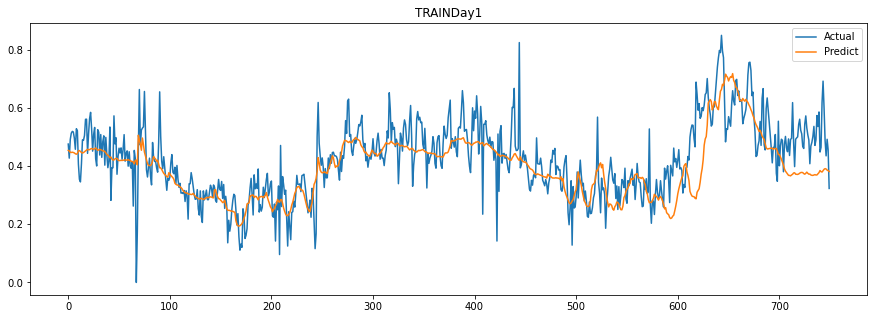

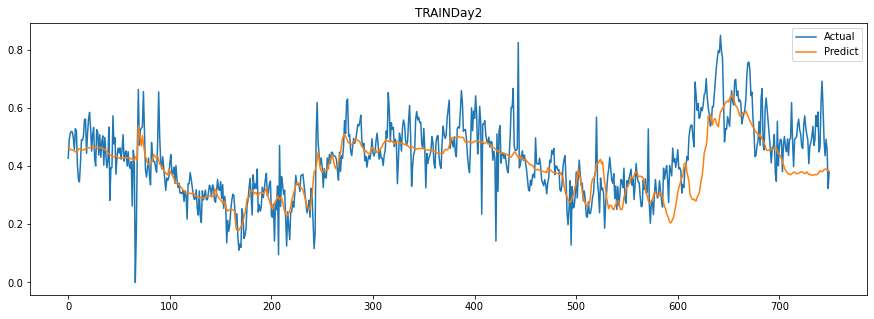

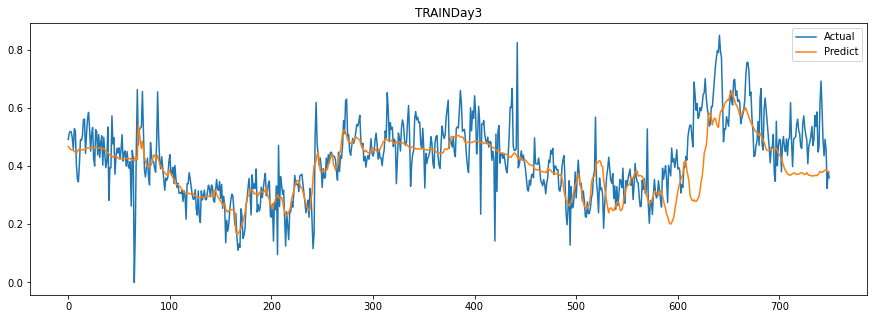

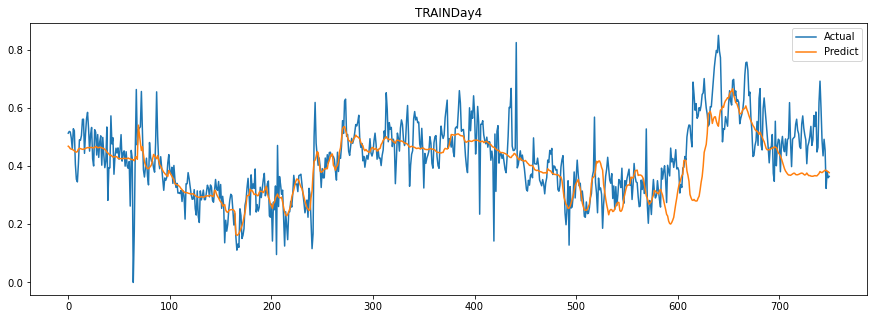

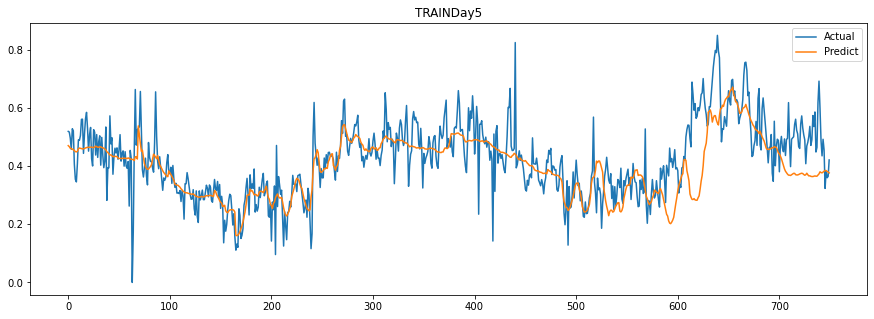

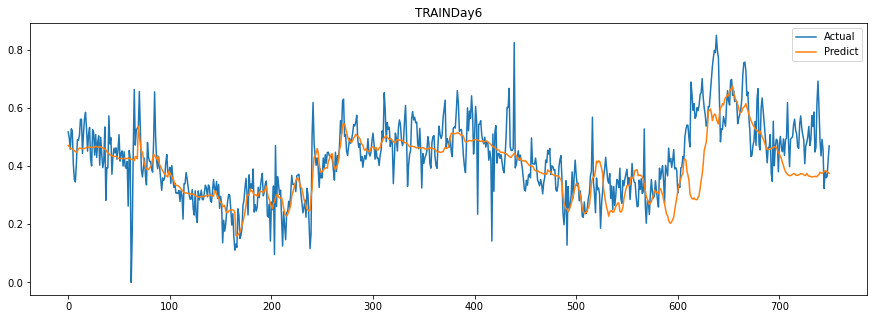

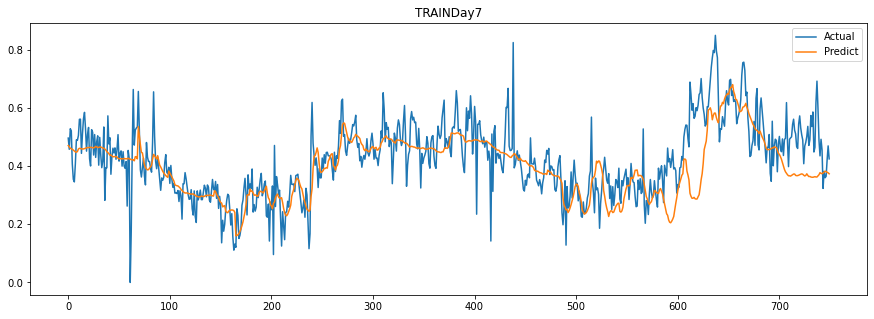

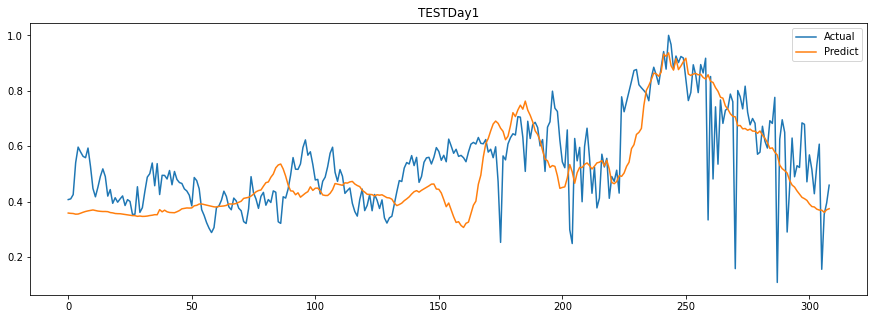

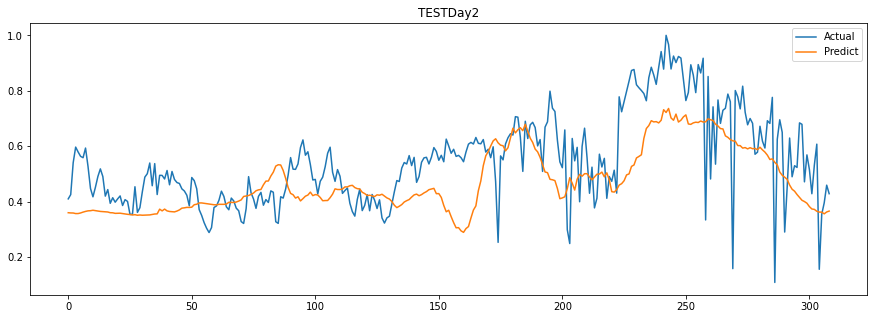

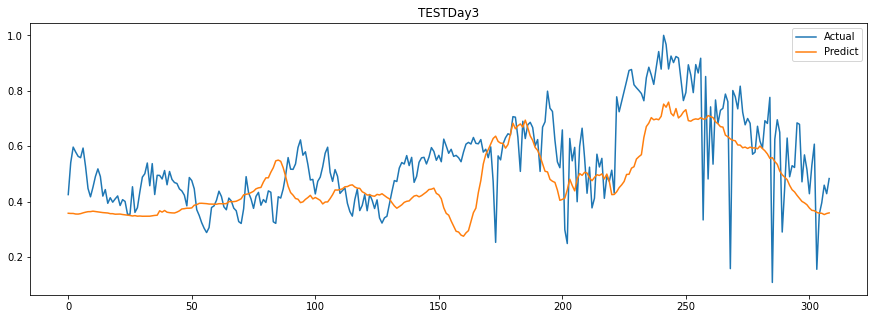

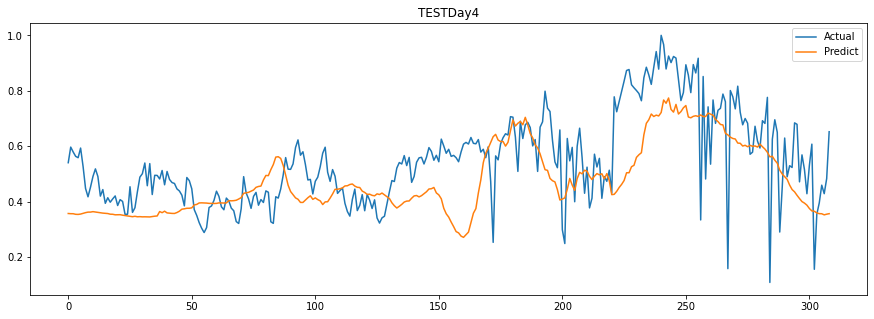

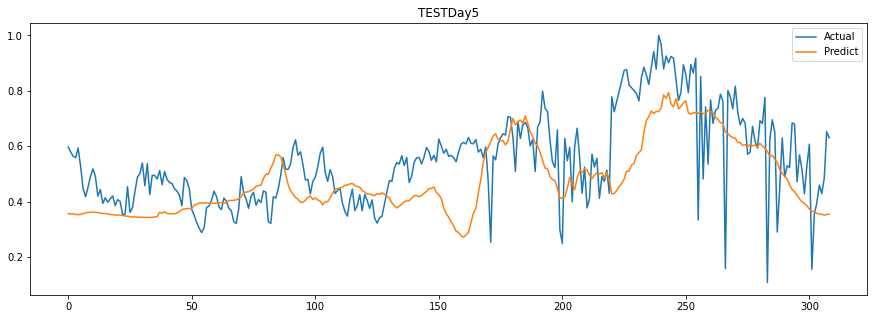

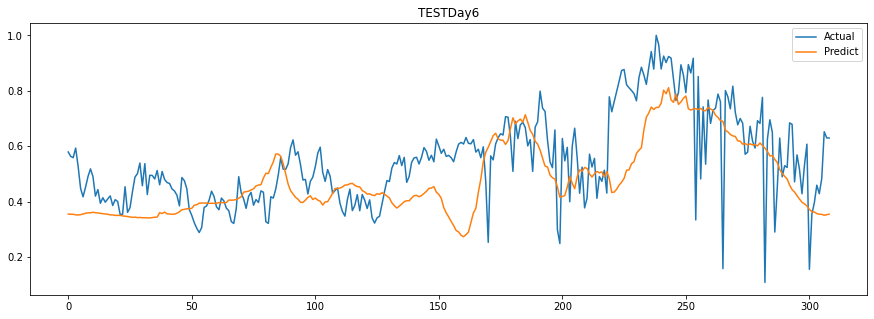

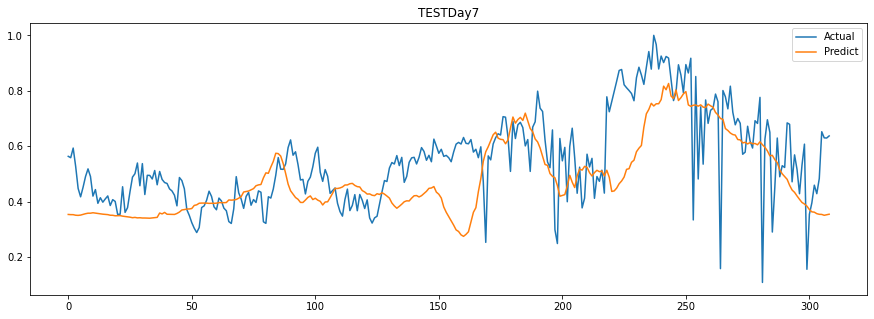

In [22]:
for i in range(n_out):
    plt.figure(figsize=(15,5))
    plt.plot(train_y[:,i], label = "Actual")
    plt.plot(trainPredict[:,i], label = "Predict")
    plt.title('TRAINDay{}'.format(i+1))
    plt.legend()
    plt.show()

for i in range(n_out):
    plt.figure(figsize=(15,5))
    plt.plot(test_y[:,i], label = "Actual")
    plt.plot(testPredict[:,i], label = "Predict")
    plt.title('TESTDay{}'.format(i+1))
    plt.legend()
    plt.show()

In [23]:
error_df = Rec("Single_LSTM",Tmse,Tnse)

In [24]:
#GET PREDICTION by keep feeding new update#
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input) # model.predict(x)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
# evaluate predictions days for each week
predictions = np.array(predictions)

In [25]:
mse,nse = list_eva_error(test[:,:,0], predictions,n_out)
for d in range(n_out):
    print("Day{}........ (test)MSE:{:.3f},NSE:{:.3f}".format(d+1,mse[d],nse[d]))

Day1........ (test)MSE:0.027,NSE:0.020
Day2........ (test)MSE:0.020,NSE:0.220
Day3........ (test)MSE:0.021,NSE:0.077
Day4........ (test)MSE:0.023,NSE:-0.076
Day5........ (test)MSE:0.028,NSE:-0.008
Day6........ (test)MSE:0.020,NSE:0.222
Day7........ (test)MSE:0.020,NSE:0.137


In [26]:
result_mse = pd.DataFrame()
result_nse = pd.DataFrame()
result_mse,result_nse = list_eva_error(test[:,:,0], predictions,n_out)

In [32]:
n_out=7
days = ["Day"+str(i+1) for i in range(n_out)]
col=["Model"]
for d in days:
  col.append("Mse_"+str(d))
for d in days:
  col.append("Nse_"+str(d))
df = pd.DataFrame(index=col)

""
Model
Mse_Day1
Mse_Day2
Mse_Day3
Mse_Day4
Mse_Day5
Mse_Day6
Mse_Day7
Nse_Day1
Nse_Day2


,0,0
Model,LSTM_seq2seq,Single_LSTM
MSE,"[0.017012203, 0.021213401, 0.021931864, 0.0220...","[0.017012203, 0.021213401, 0.021931864, 0.0220..."
NSE,"[0.35141628980636597, 0.19070076942443848, 0.1...","[0.35141628980636597, 0.19070076942443848, 0.1..."
